In [12]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [13]:
# Base path for RAVDESS dataset
base_path_RAVDESS = '/kaggle/input/ravdess-emotional-speech-audio'
# Base path for TESS dataset
base_path_TESS = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data'

# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack((np.mean(mfccs, axis=1), np.mean(chroma, axis=1), 
                              np.mean(mel, axis=1), np.mean(contrast, axis=1)))
        return features
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}")
        return None

# Recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.wav'):
                audio_files.append(os.path.join(root, file))
    return audio_files

# Get all audio files from RAVDESS and TESS datasets
audio_files_ravdess = get_audio_files(base_path_RAVDESS)
audio_files_tess = get_audio_files(base_path_TESS)
audio_files = audio_files_ravdess + audio_files_tess

# Extract features from all audio files
features = []
labels = []
for idx, file in enumerate(audio_files, start=1):
    feature = extract_features(file)
    if feature is not None:
        features.append(feature)
        if 'ravdess' in file:
            # Extract label from RAVDESS file name
            label = file.split('/')[-1].split('-')[2]
        else:
            # Extract label from TESS file path
            emotion = file.split('/')[-2]
            label_map_tess = {
                'OAF_angry': '05',
                'OAF_disgust': '08',
                'OAF_Fear': '06',
                'OAF_happy': '03',
                'OAF_Pleasant_surprise': '08',
                'OAF_Sad': '04',
                'OAF_neutral': '01',
                'YAF_angry': '05',
                'YAF_disgust': '08',
                'YAF_fear': '06',
                'YAF_happy': '03',
                'YAF_pleasant_surprised': '08',
                'YAF_sad': '04',
                'YAF_neutral': '01'
            }
            label = label_map_tess[emotion]
        labels.append(label)
        clear_output(wait=True)
        print(f"Processing file {idx} of {len(audio_files)}")

print("Feature extraction complete.")

Processing file 5680 of 5680
Feature extraction complete.


In [14]:
# Convert labels to integers (0-7 for 8 emotions)
label_map_ravdess = {
    '01': 0, '02': 1, '03': 2, '04': 3,
    '05': 4, '06': 5, '07': 6, '08': 7
}

y = np.array([label_map_ravdess[label] for label in labels])

In [15]:
# Print unique labels to verify
print("Unique labels in y_train:", np.unique(y))

Unique labels in y_train: [0 1 2 3 4 5 6 7]


In [16]:
# Convert the features and labels into numpy arrays
X = np.array(features)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape data to fit the model: (num_samples, timesteps, num_features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [17]:
# Initialize a sequential model
model = Sequential()

# First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
# Input shape is (num_features, 1)
model.add(Conv1D(64, 5, padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Flatten the output for the dense layer
model.add(Flatten())

# Dense layer with 8 units and softmax activation for multi-class classification
model.add(Dense(8))
model.add(Activation('softmax'))

# Define the RMSprop optimizer with a lower learning rate
opt = RMSprop(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and the defined optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 187, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 11, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,104 (891.03 KB)

 Trainable params: 228,104 (891.03 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the model with sparse categorical crossentropy loss and the defined optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
# Ensure X_train and X_test are reshaped correctly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3526 - loss: 4.1421 - val_accuracy: 0.6039 - val_loss: 1.0797
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6228 - loss: 1.0402 - val_accuracy: 0.6320 - val_loss: 0.9897
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6569 - loss: 0.9050 - val_accuracy: 0.6831 - val_loss: 0.9064
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6871 - loss: 0.8453 - val_accuracy: 0.6857 - val_loss: 0.8673
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7131 - loss: 0.7790 - val_accuracy: 0.6910 - val_loss: 0.8453
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7431 - loss: 0.7005 - val_accuracy: 0.7104 - val_loss: 0.8392
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7580 - loss: 0.6687 - val_accuracy: 0.7570 - val_loss: 0.7611
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7607 - loss: 0.6419 - val_accu

Test accuracy: 0.9419013857841492
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       118
           1       0.80      0.95      0.87        77
           2       0.95      0.92      0.94       157
           3       0.92      0.94      0.93       156
           4       0.94      0.99      0.96       157
           5       0.95      0.95      0.95       157
           6       0.94      0.87      0.91        77
           7       0.99      0.97      0.98       237

    accuracy                           0.94      1136
   macro avg       0.93      0.93      0.93      1136
weighted avg       0.94      0.94      0.94      1136



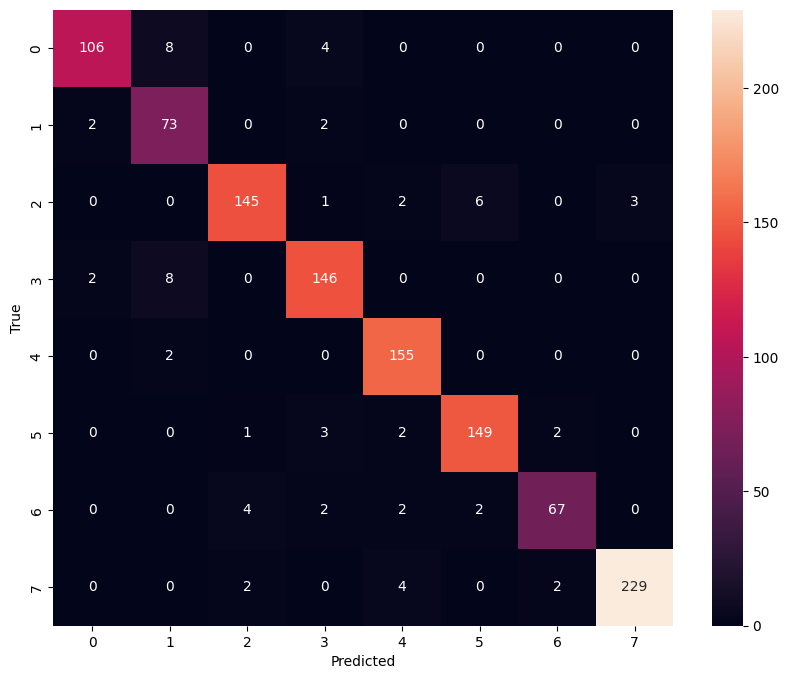

In [20]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {score[1]}')

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

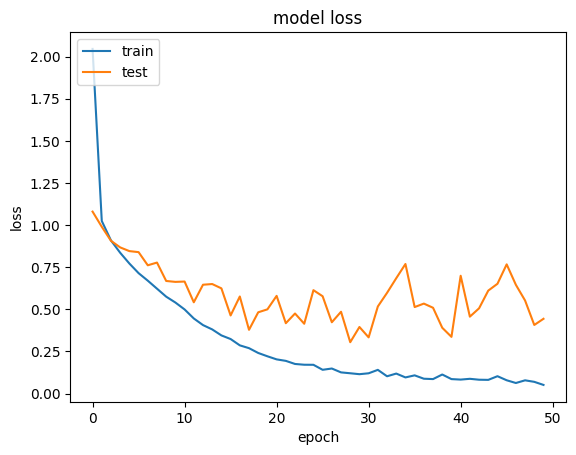

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

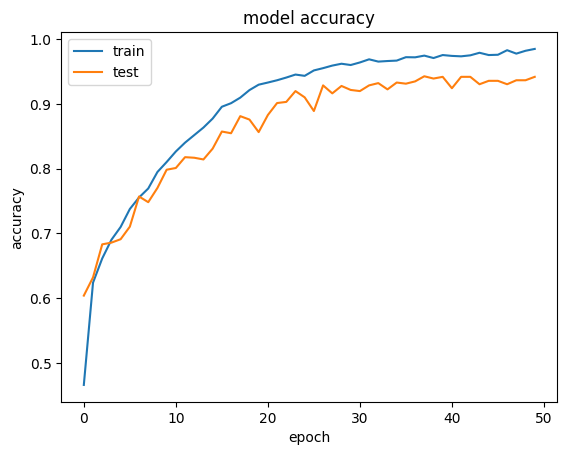

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()